# F20PA

## Artificial Neural Network Model

In [1]:
# import required libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
# import the data
df = pd.read_csv("Monthly Rainfall Index and Flood Probability Kerala.csv")

df.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL RAINFALL,FLOODS
0,KERALA,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,3248.6,YES
1,KERALA,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,3326.6,YES
2,KERALA,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,3271.2,YES
3,KERALA,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,3129.7,YES
4,KERALA,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,2741.6,NO


### Exploratory Data Analysis

In [3]:
# get a summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SUBDIVISION       118 non-null    object 
 1   YEAR              118 non-null    int64  
 2   JAN               118 non-null    float64
 3   FEB               118 non-null    float64
 4   MAR               118 non-null    float64
 5   APR               118 non-null    float64
 6   MAY               118 non-null    float64
 7   JUN               118 non-null    float64
 8   JUL               118 non-null    float64
 9   AUG               118 non-null    float64
 10  SEP               118 non-null    float64
 11  OCT               118 non-null    float64
 12  NOV               118 non-null    float64
 13  DEC               118 non-null    float64
 14   ANNUAL RAINFALL  118 non-null    float64
 15  FLOODS            118 non-null    object 
dtypes: float64(13), int64(1), object(2)
memory u

We can see that there are no missing values in the dataset

In [4]:
# encode the FLOODS feature with 0 and 1
df['FLOODS'] = df['FLOODS'].replace('YES', 1)
df['FLOODS'] = df['FLOODS'].replace('NO', 0)

# drop the following features
df.drop(['SUBDIVISION', ' ANNUAL RAINFALL', 'YEAR'], axis=1, inplace=True)

In [5]:
df.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,FLOODS
0,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,1
1,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,1
2,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,1
3,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,1
4,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,0


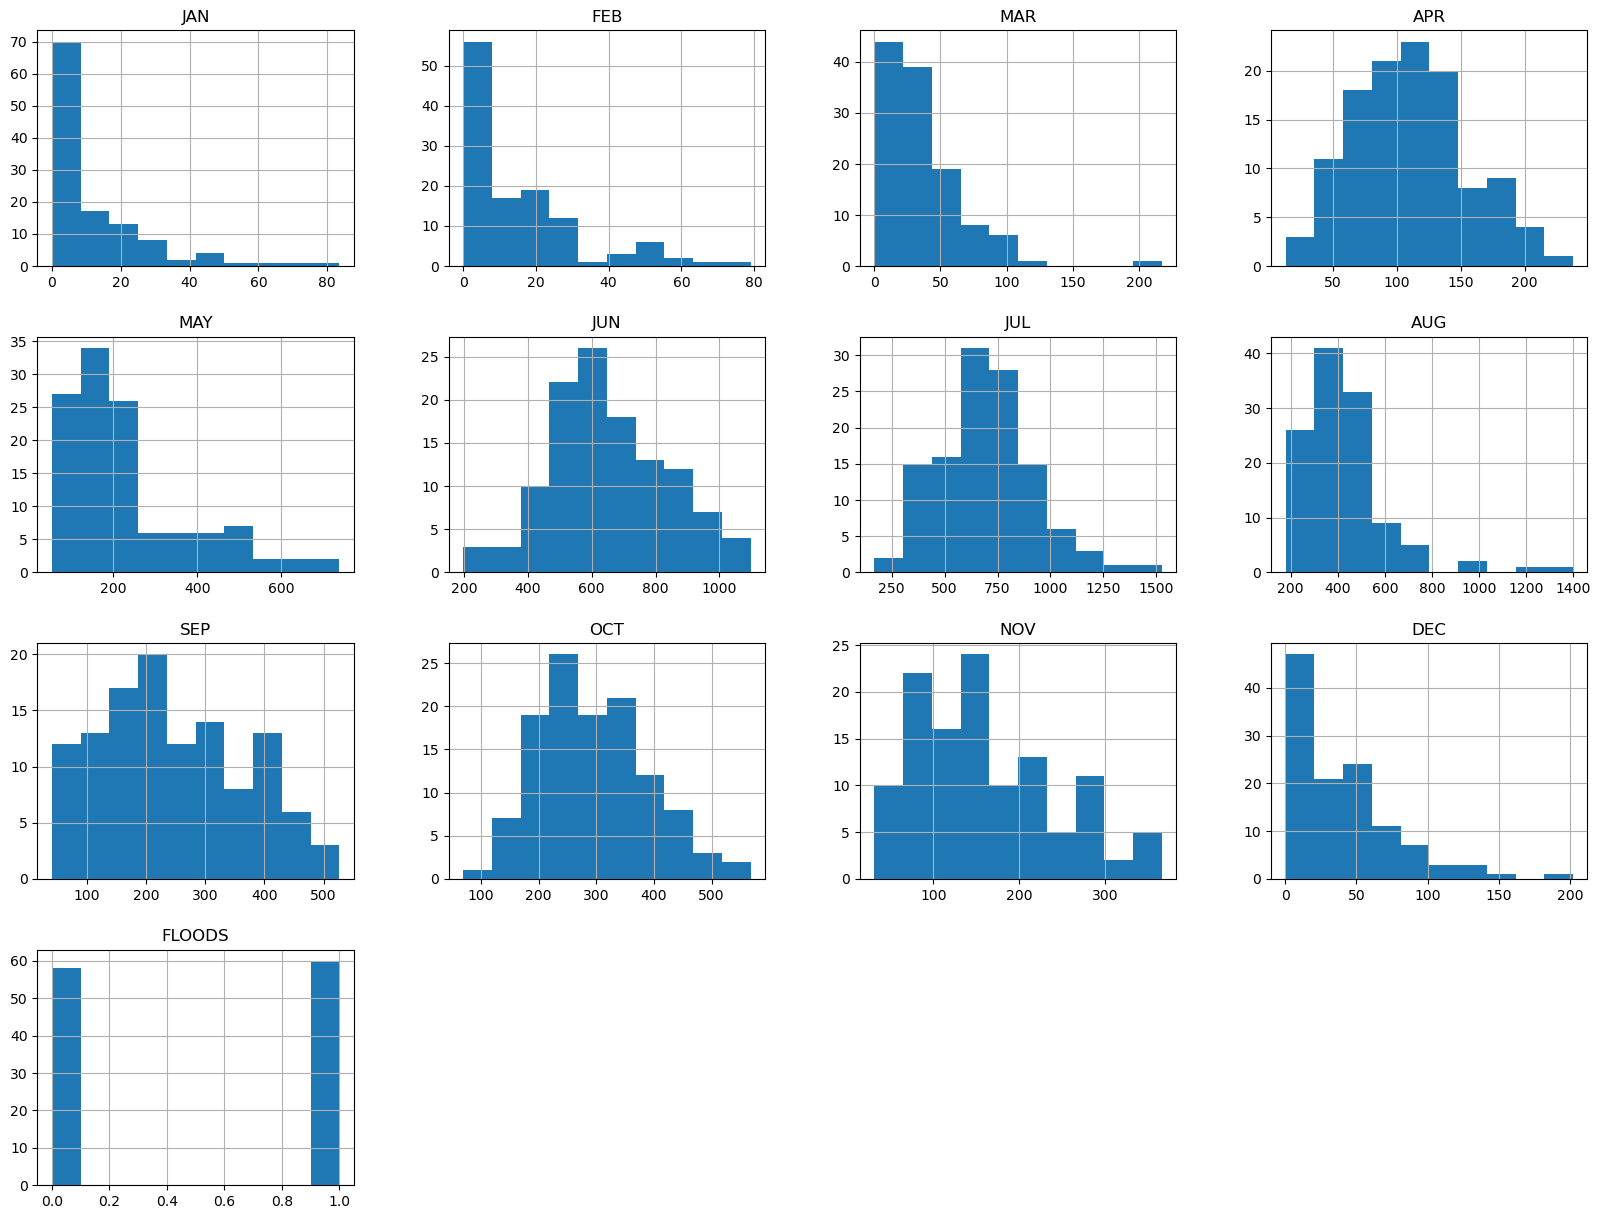

In [6]:
# see the distribution of the data for the different features
df.hist(bins=10, figsize=(20,15))
plt.show()

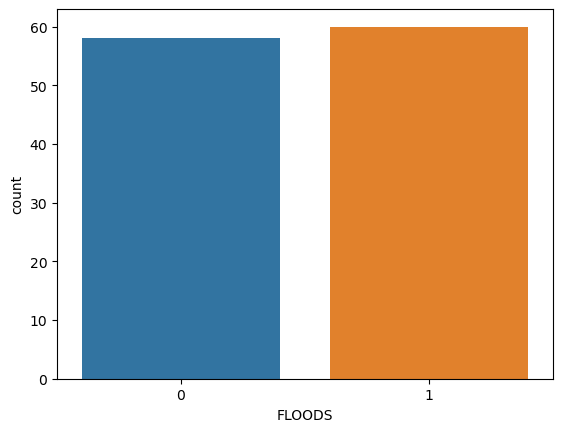

In [7]:
# display the count of floods and no-floods
sns.countplot(data=df,x='FLOODS')
plt.show()

In [8]:
# check the correlation of FLOODS feature with all other features
corr_matrix = df.corr()
corr_matrix['FLOODS'].sort_values(ascending=False)

FLOODS    1.000000
JUL       0.442774
JUN       0.442531
SEP       0.376385
AUG       0.286690
MAY       0.242813
NOV       0.238852
JAN       0.145313
MAR       0.086739
OCT       0.060088
DEC       0.054326
APR       0.034392
FEB      -0.035730
Name: FLOODS, dtype: float64

We can see that none of the other features have a strong correlation with the FLOODS feature which is the target class

<AxesSubplot:>

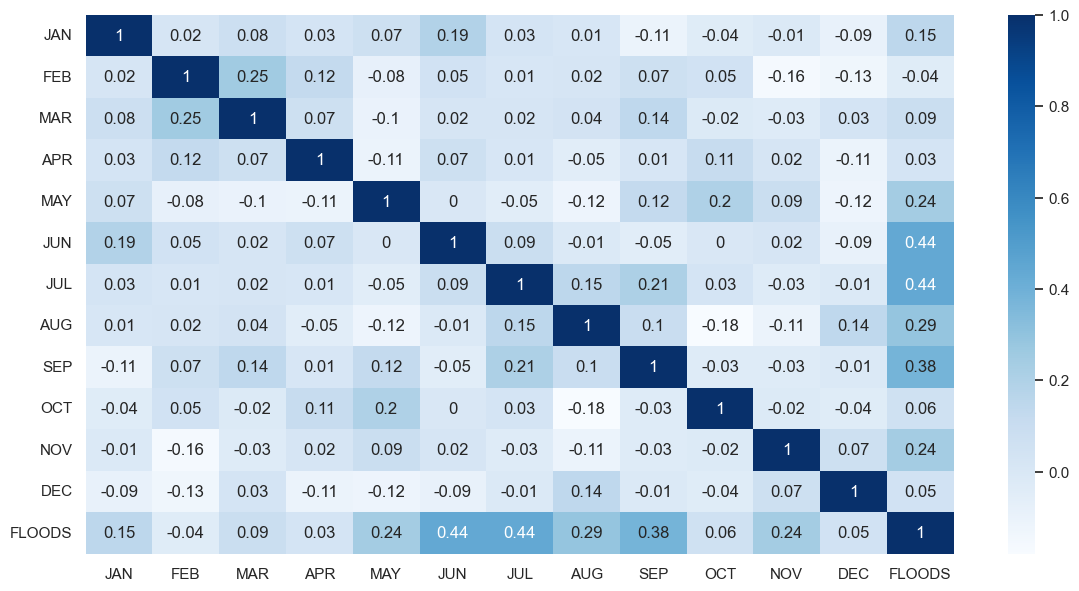

In [9]:
# display the heatmap of correlation between all features
corr_matrix = df.corr().round(2)
sns.set(font_scale=1)
plt.figure(figsize = (14,7))
sns.heatmap(corr_matrix, annot = True, cmap='Blues')

In [10]:
# import functions for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
# store the features for prediction in X and the target class in y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# use standard scaling to scale the data for training the model
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [13]:
# import libraries for building the model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping

In [43]:
# define the function to build the model for keras tuner
def ann_model_builder(hp):
    ann = Sequential()

    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=14, step=1)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=101, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    ann.add(Dense(units=hp_layer_1, activation='relu'))
    ann.add(Dense(units=hp_layer_2, activation='relu'))
    ann.add(Dense(units=1, activation='sigmoid'))

    ann.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=BinaryCrossentropy(), metrics=['accuracy'])

    return ann

In [44]:
# import keras tuner for hyperparameter tuning
import keras_tuner as kt

In [45]:
# define the tuner
ktuner = kt.Hyperband(
    ann_model_builder,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='dir',
    overwrite=True
)

In [46]:
# early stopping to stop training when val_loss for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [47]:
# serach for the model with best hyperparameters
ktuner.search(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Trial 90 Complete [00h 00m 02s]
val_accuracy: 0.699999988079071

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 35s
INFO:tensorflow:Oracle triggered exit


In [48]:
# get the best hyperparameters
best_hyperparameters = ktuner.get_best_hyperparameters(num_trials=1)[0]

In [49]:
# get and train the best model
ann_model =  ktuner.hypermodel.build(best_hyperparameters)
history = ann_model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 0s 84ms/step - loss: 0.7126 - accuracy: 0.4643 - val_loss: 0.7188 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 0.6308 - accuracy: 0.7262 - val_loss: 0.7414 - val_accuracy: 0.3000
Epoch 3/50
3/3 [==============================] - 0s 13ms/step - loss: 0.5774 - accuracy: 0.7262 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 0.5227 - accuracy: 0.7976 - val_loss: 0.6246 - val_accuracy: 0.7000
Epoch 5/50
3/3 [==============================] - 0s 12ms/step - loss: 0.4694 - accuracy: 0.8095 - val_loss: 0.5565 - val_accuracy: 0.8000
Epoch 6/50
3/3 [==============================] - 0s 12ms/step - loss: 0.4130 - accuracy: 0.8452 - val_loss: 0.5059 - val_accuracy: 0.8000
Epoch 7/50
3/3 [==============================] - 0s 14ms/step - loss: 0.3571 - accuracy: 0.8810 - val_loss: 0.4447 - val_accuracy: 0.8000
Epoch 8/50
3/3 [===========

In [51]:
# get the summary of the model
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 13)                169       
                                                                 
 dense_4 (Dense)             (None, 37)                518       
                                                                 
 dense_5 (Dense)             (None, 1)                 38        
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________


In [52]:
# get the predictions for the testing set
y_pred = ann_model.predict(X_test)

1/1 [==============================] - 0s 35ms/step


In [53]:
# transform y_pred to run performance metrics on it with y_test
y_pred = (y_pred>0.5)

y_pred = y_pred.reshape(-1)

y_pred = y_pred.astype(int)

In [54]:
# import functions for performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

<AxesSubplot:>

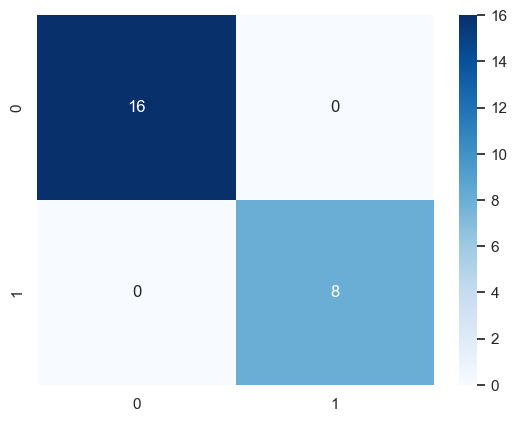

In [55]:
# plot the confustion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [56]:
# get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [57]:
# get the accuracy and f1_score
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy Score:  1.0
F1 Score:  1.0


In [59]:
# save the model for future use
ann_model.save('flood_prediction_model.h5')

The model achieves 100% accuracy and F1 score on the testing set.

---

## Time Series Model

In [1]:
# import all the required libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
assert sklearn.__version__ >= "0.20"

from datetime import datetime
from time import time
import os

from math import sqrt
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax as SARIMAX
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data
df1 = pd.read_csv("Monthly Rainfall Index Kerala Time Series.csv", index_col="Date", parse_dates=True)
df1.head()

,Rainfall(mm)
Date,
1901-01-01,28.7
1901-02-01,44.7
1901-03-01,51.6
1901-04-01,160.0
1901-05-01,174.7


In [3]:
# get a summary of the data
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1416 entries, 1901-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rainfall(mm)  1416 non-null   float64
dtypes: float64(1)
memory usage: 22.1 KB


We see that there are no missing values

In [4]:
# get some basic statistics of the data
df1.describe()

,Rainfall(mm)
count,1416.000000
mean,243.786794
std,258.398667
min,0.000000
25%,35.275000
50%,154.700000
75%,371.350000
max,1526.500000


In [5]:
# split the data into training and testing sets
train = df1.iloc[:-36, :]
test = df1.iloc[-36:, :]

### Time Series Analysis

<AxesSubplot:xlabel='Date'>

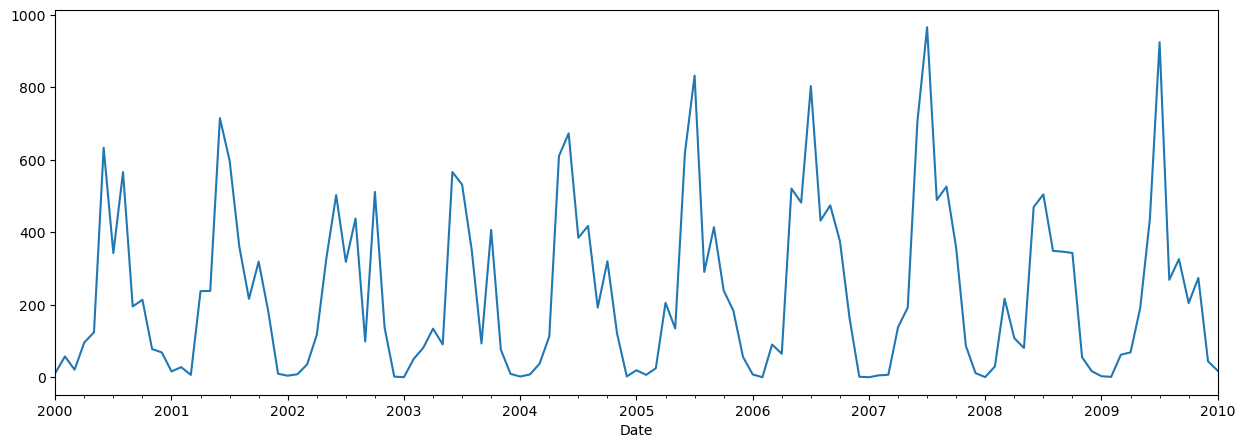

In [6]:
# plot the data for 10 years for better visibility
plt.figure(figsize=(15,5))
train['Rainfall(mm)']['2000-01-01':'2010-01-01'].plot()

#### Stationarity Test

Rolling Statistics Test:


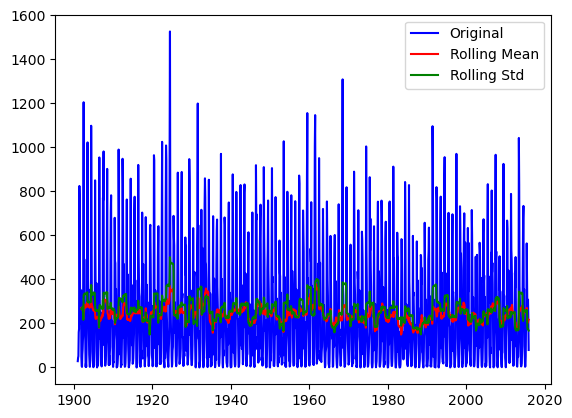

Dickey-Fuller Test:
ADF Statistic: -5.631022
p-value: 0.000001
Critical Values:
1% -3.4351852261663867
5% -2.863675384893896
10% -2.5679068804891


In [7]:
# Determine rolling mean and standard deviation
rolling_mean = train['Rainfall(mm)'].rolling(window=12).mean()
rolling_std = train['Rainfall(mm)'].rolling(window=12).std()

# Plot rolling statistics:
print("Rolling Statistics Test:")
original = plt.plot(train['Rainfall(mm)'], color='blue',label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.show()

# Perform Dickey-Fuller test:
print('Dickey-Fuller Test:')
adfuller_test = adfuller(train['Rainfall(mm)'], autolag='AIC')
print('ADF Statistic: %f' % adfuller_test[0])
print('p-value: %f' % adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
        print(key, value)

The ADF Statistic value is lower than the 1% and 5% critical values, and the p-value is 0.000001 which is much lower than 0.05

We see from the two tests that the data has stationarity and no transformation has to be done to make it stationary.

#### Seasonal Decomposition

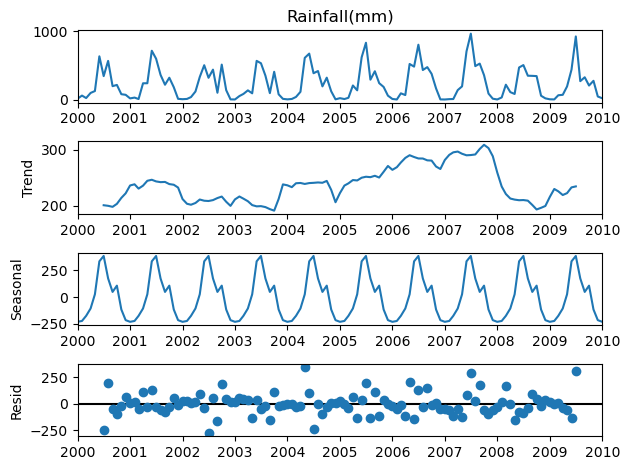

In [8]:
# plot the seasonality decomposition for 2000 to 2010
seasonal_decomposition = seasonal_decompose(train['Rainfall(mm)']['2000-01-01':'2010-01-01'], period = 12).plot()
plt.show()

We can observe that there is no trend but there is seasonality in the data, and so the seasonality will have to be taken into account when making the model for forecasting.

#### SARIMA (Seasonal Autoregressive Integrated Moving Average)

Text(0.5, 1.0, 'PACF')

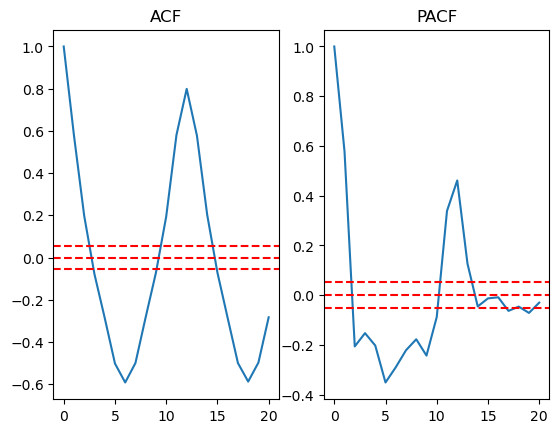

In [9]:
# plot the Autocorrelation function plot
lag_acf = acf(train)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color ='red')
plt.axhline(y=1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.axhline(y=-1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.title('ACF')

# plot the Partial Autocorrelation plot
lag_pacf = pacf(train, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color ='red')
plt.axhline(y=1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.axhline(y=-1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.title('PACF')

In [10]:
# resample the data based on month start with the mean rainfall of each month
train_sarima = train.resample("MS").mean() 
train_sarima = train_sarima[["Rainfall(mm)"]]

##### Hyperparameter tuning

In [12]:
# p, d, and q are any values from 0 to 3
p = d = q = range(0, 4)

# get all combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# get all comibinations of p, d, q and m=12 
s_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
min_aic = 10**5

for val in pdq:
    for val_seasonal in s_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                train_sarima,
                order=val,
                seasonal_order=val_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            results = mod.fit()

            if (results.aic <= min_aic):
                min_aic = results.aic
                print('SARIMA:{}x{} - AIC:{}'.format(val, val_seasonal, results.aic))

        except:
            continue

SARIMA:(0, 0, 0)x(0, 0, 0, 12) - AIC:20107.237637268718
SARIMA:(0, 0, 0)x(0, 0, 1, 12) - AIC:19011.34750228115
SARIMA:(0, 0, 0)x(0, 0, 2, 12) - AIC:18364.314082955185
SARIMA:(0, 0, 0)x(0, 0, 3, 12) - AIC:17928.723315635427
SARIMA:(0, 0, 0)x(0, 1, 0, 12) - AIC:17780.003739578613
SARIMA:(0, 0, 0)x(0, 1, 1, 12) - AIC:16832.71305768952
SARIMA:(0, 0, 0)x(0, 1, 2, 12) - AIC:16702.04625258364
SARIMA:(0, 0, 0)x(0, 1, 3, 12) - AIC:16524.348148101133
SARIMA:(0, 0, 0)x(0, 2, 3, 12) - AIC:16510.58304779447
SARIMA:(0, 0, 0)x(1, 2, 3, 12) - AIC:16502.639154831795
SARIMA:(0, 0, 0)x(2, 2, 3, 12) - AIC:16487.989221504664
SARIMA:(0, 0, 1)x(1, 2, 3, 12) - AIC:16477.81021288278
SARIMA:(0, 0, 3)x(1, 2, 3, 12) - AIC:16458.835749359117


From the search we see that the combination of (0, 0, 3)x(1, 2, 3, 12) has the lowest AIC score of 16458.835749359117 which makes the best. So this combination will be used for the SARIMA model

##### Building the model with best hyperparameters

In [11]:
sarima_model = sm.tsa.statespace.SARIMAX(
    train_sarima,
    order=(0, 0, 3),
    seasonal_order=(1, 2, 3, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit()

print(sarima_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0473      0.020      2.338      0.019       0.008       0.087
ma.L2         -0.0057      0.025     -0.231      0.817      -0.055       0.043
ma.L3         -0.0375      0.033     -1.153      0.249      -0.101       0.026
ar.S.L12      -0.8625      0.045    -19.061      0.000      -0.951      -0.774
ma.S.L12      -1.1461      0.055    -20.673      0.000      -1.255      -1.037
ma.S.L24      -0.7527      0.088     -8.543      0.000      -0.925      -0.580
ma.S.L36       0.9002      0.055     16.241      0.000       0.792       1.009
sigma2      1.361e+04    551.300     24.683      0.000    1.25e+04    1.47e+04


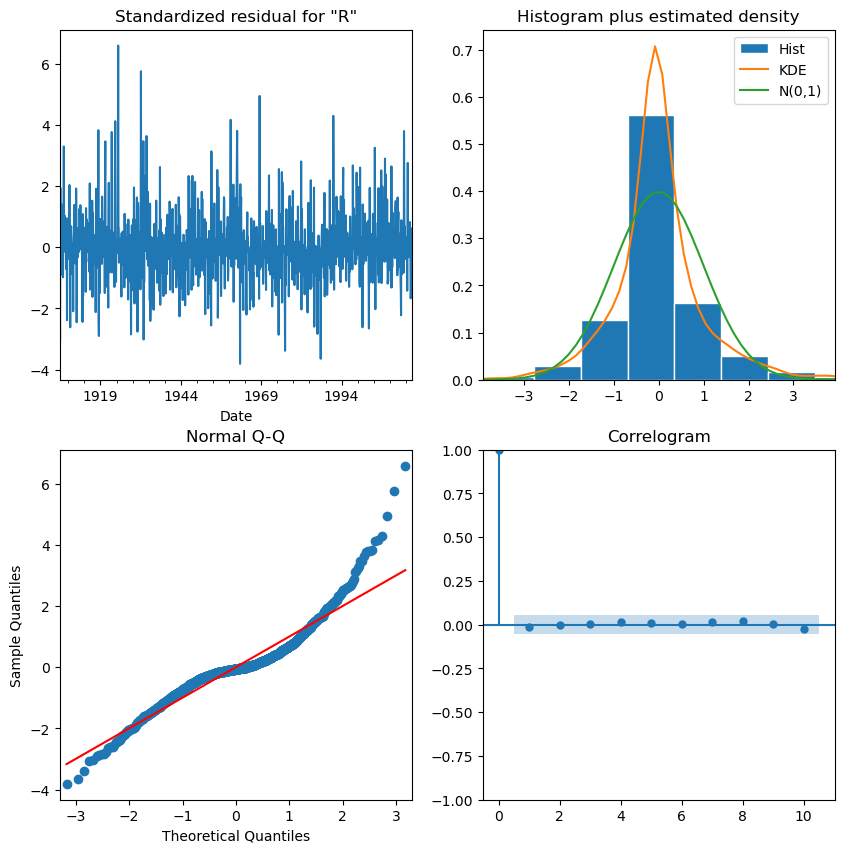

In [12]:
sarima_results.plot_diagnostics(figsize=(10, 10))
plt.show()

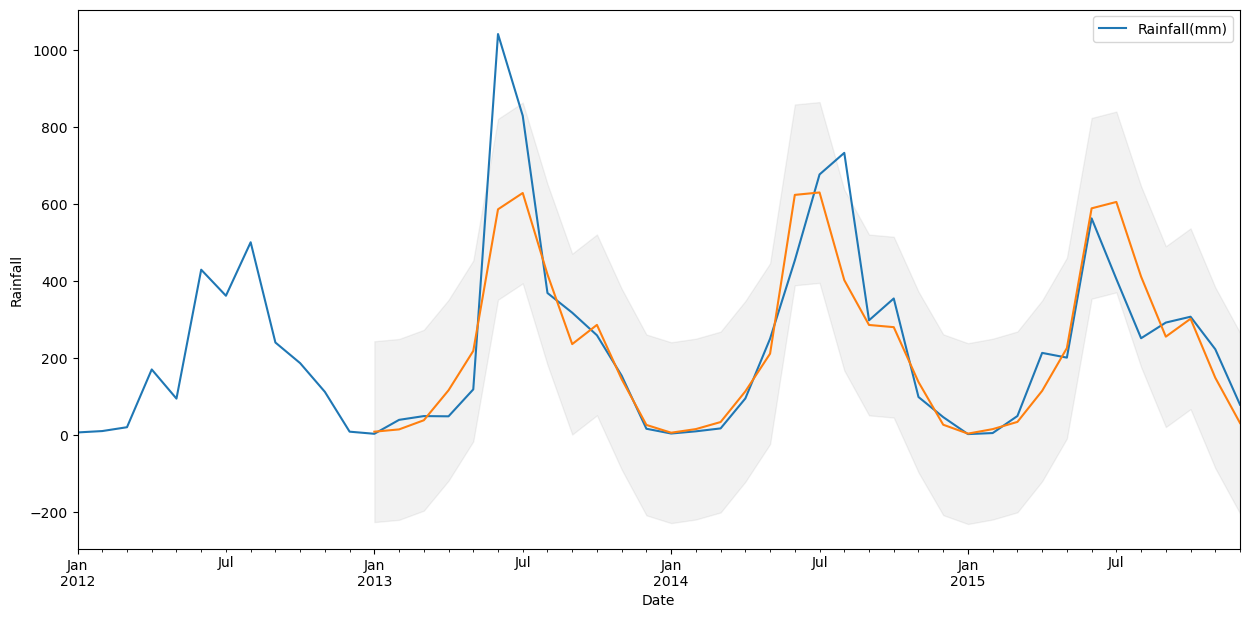

Root Mean Squared Error:  118.96432178680983


In [13]:
# Prediction on Training Set 
# Predictions are performed for the 1st January 2013 onwards of the train data.

train_pred = sarima_results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic = False) 

# Get confidence intervals of predictions
train_pred_ci = train_pred.conf_int() 

ax = train_sarima["2012":].plot(label="observed", figsize=(15, 7))
train_pred.predicted_mean.plot(ax = ax, alpha = 1)
ax.fill_between(
    train_pred_ci.index, 
    train_pred_ci.iloc[:, 0], 
    train_pred_ci.iloc[:, 1], 
    color = "k", alpha = 0.05
)
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall")
plt.legend
plt.show()

train_sarima_prediction = train_pred.predicted_mean
train_sarima_true = train_sarima["2013-01-01":]

# Calculating the RMSE
rmse_sarima = sqrt(mean_squared_error(train_sarima_true, train_sarima_prediction))
print("Root Mean Squared Error: ", rmse_sarima)

In [14]:
# Prediction on Testing Set 
test_predictions = pd.Series(sarima_results.predict(start=len(train), end=len(train)+len(test)-1))
test_predictions.index = test.index
test_predictions.head()

Date
2016-01-01      7.491772
2016-02-01     12.736337
2016-03-01     33.237158
2016-04-01    119.192628
2016-05-01    212.459082
Name: predicted_mean, dtype: float64

Root Mean Squared Error:  198.37873977732943


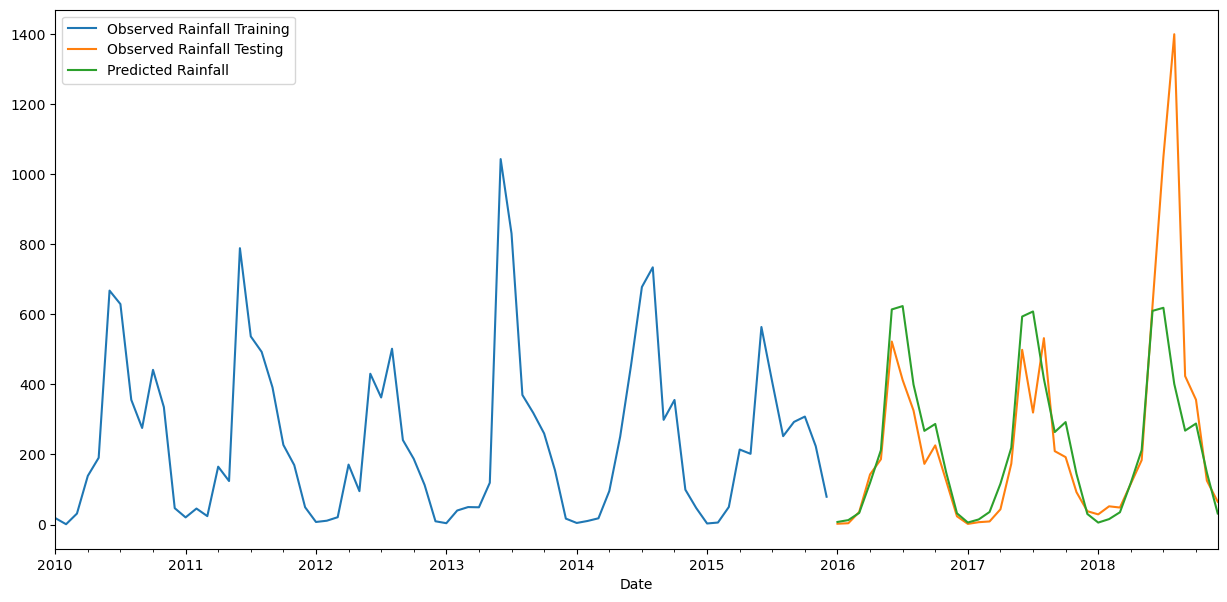

In [15]:
train['Rainfall(mm)']['2010-01-01':].plot(figsize=(15,7), legend=True, label="Observed Rainfall Training")
test['Rainfall(mm)'].plot(legend=True, label="Observed Rainfall Testing")
test_predictions.plot(legend=True, label="Predicted Rainfall")


test_sarima_prediction = test_predictions
test_sarima_true = test

# Calculate the RMSE
rmse_sarima = sqrt(mean_squared_error(test_sarima_true, test_sarima_prediction))
print("Root Mean Squared Error: ", rmse_sarima)

In [16]:
sarima_results.predict(start=len(train)+len(test)+48, end=len(train)+len(test)+60-1)

2023-01-01      5.192160
2023-02-01     14.910600
2023-03-01     35.728264
2023-04-01    117.897430
2023-05-01    214.175069
2023-06-01    594.710703
2023-07-01    602.725685
2023-08-01    409.395325
2023-09-01    268.668042
2023-10-01    292.312034
2023-11-01    144.553576
2023-12-01     29.702469
Freq: MS, Name: predicted_mean, dtype: float64

## Future Flood Prediction for 2023

In [1]:
# import the required libraries
import numpy as np
import pandas as pd
import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# load the ANN model
flood_prediction_model = keras.models.load_model('flood_prediction_model.h5')

In [3]:
df = pd.read_csv("Monthly Rainfall Index and Flood Probability Kerala.csv")

df['FLOODS'] = df['FLOODS'].replace('YES', 1)
df['FLOODS'] = df['FLOODS'].replace('NO', 0)
df.drop(['SUBDIVISION', ' ANNUAL RAINFALL', 'YEAR'], axis=1, inplace=True)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)

In [4]:
# store the 2023 data into a DataFrame
df_rainfall_2023 = pd.DataFrame(
    np.array([[5.192160, 14.910600, 35.728264, 117.897430, 214.175069, 594.710703, 
    602.725685, 409.395325, 268.668042, 292.312034, 144.553576, 29.702469]]), 
    columns=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
)

df_rainfall_2023

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,5.19216,14.9106,35.728264,117.89743,214.175069,594.710703,602.725685,409.395325,268.668042,292.312034,144.553576,29.702469


In [5]:
# make the prediction for the 2023 data
print(flood_prediction_model.predict(std_scaler.transform(df_rainfall_2023)))

1/1 [==============================] - 0s 89ms/step
[[0.00168264]]


c:\Users\jishn\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [65]:
# get the flood prediction for 2023 data
pred = flood_prediction_model.predict(std_scaler.transform(df_rainfall_2023))

if (pred > 0.5):
    print("A flood is predicted for 2023")
else:
    print("No flood is predicted for 2023")

1/1 [==============================] - 0s 12ms/step
No flood is predicted for 2023


c:\Users\jishn\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
